In [ ]:
# ✅ Mount Drive & Setup
from google.colab import drive
drive.mount('/content/drive')
!pip install mne tensorflow seaborn --quiet

import os, math, warnings, pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.utils import Sequence

warnings.filterwarnings("ignore")

# ✅ Constants
BASE_DATA_PATH = '/content/drive/MyDrive/BILSTM_MODEL/edf_files/'
ANNOTATION_BASE_PATH = '/content/drive/MyDrive/BILSTM_MODEL/textfile/'
CHUNK_SIZE_SECONDS = 5
SAMPLING_RATE = 256

# ✅ Helper Functions
def time_str_to_seconds(t_str):
    h, m, s = map(int, t_str.split('.'))
    return h * 3600 + m * 60 + s

def load_edf(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.resample(SAMPLING_RATE)
    return raw

def load_seizure_times(annotation_path):
    times = []
    reg_start = None
    with open(annotation_path, 'r') as f:
        for line in f:
            if 'Registration start time:' in line:
                reg_start = time_str_to_seconds(line.strip().split(': ')[1])
            elif 'Seizure start time:' in line and reg_start is not None:
                seizure_time = time_str_to_seconds(line.strip().split(': ')[1])
                times.append(seizure_time - reg_start)
    return times

def segment_eeg(raw, start, end):
    sfreq = int(raw.info['sfreq'])
    data = raw.get_data()
    chunks = []
    for t in range(start, end - CHUNK_SIZE_SECONDS + 1, CHUNK_SIZE_SECONDS):
        s, e = t * sfreq, (t + CHUNK_SIZE_SECONDS) * sfreq
        chunk = data[:, s:e]
        with np.errstate(divide='ignore', invalid='ignore'):
            norm = (chunk - np.mean(chunk, axis=1, keepdims=True)) / np.std(chunk, axis=1, keepdims=True)
            norm = np.nan_to_num(norm)
        chunks.append(norm.T)
    return chunks

def create_dataset_from_file(file_name):
    raw = load_edf(os.path.join(BASE_DATA_PATH, file_name))
    annotation_file = 'Seizures-list-' + file_name.split('-')[0] + '.txt'
    seizure_times = load_seizure_times(os.path.join(ANNOTATION_BASE_PATH, annotation_file))
    total_sec = int(raw.n_times / raw.info['sfreq'])
    preictal, interictal = [], []
    for sz in seizure_times:
        preictal.extend(segment_eeg(raw, max(0, sz - 1800), sz))
        if sz + 1200 < total_sec:
            interictal.extend(segment_eeg(raw, sz + 600, sz + 1200))
    return preictal, interictal

class EEGDataGenerator(Sequence):
    def __init__(self, x, y, batch_size=8):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(x))
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        return np.array([self.x[i] for i in batch_idx]), np.array([self.y[i] for i in batch_idx])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X, Y = [], []
edf_files = [f for f in os.listdir(BASE_DATA_PATH) if f.endswith('.edf')]
for f in edf_files:
    pre, inter = create_dataset_from_file(f)
    X.extend(pre)
    Y.extend([1]*len(pre))
    X.extend(inter)
    Y.extend([0]*len(inter))

X = np.array(X)
Y = np.array(Y)

_, X_test, _, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
test_generator = EEGDataGenerator(X_test, Y_test)

print(f"✅ Test set ready: {len(X_test)} samples")


✅ Test set ready: 1390 samples


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🎯 Test Accuracy: 83.53%


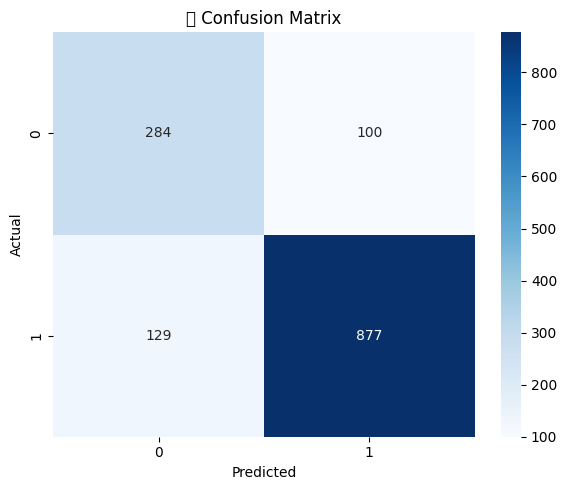


📈 Plotting training curves...


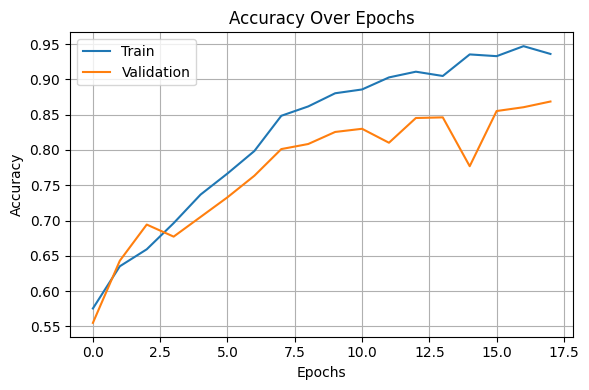

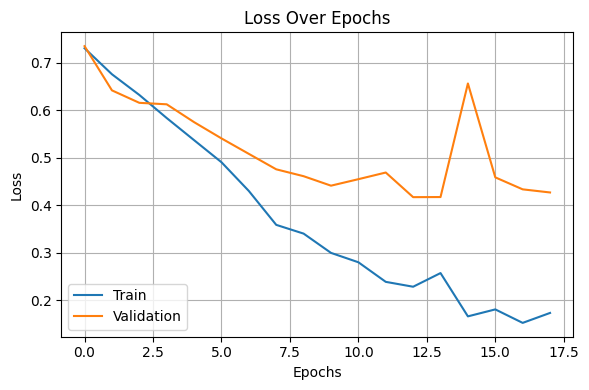

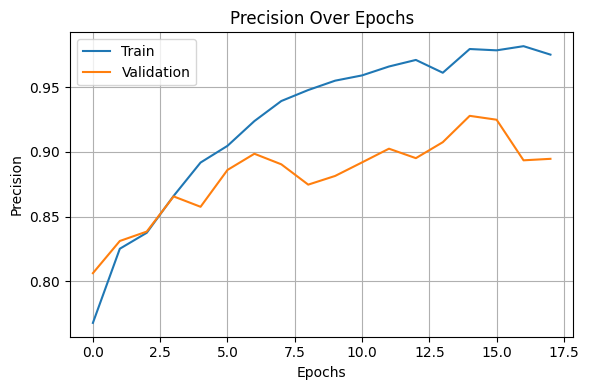

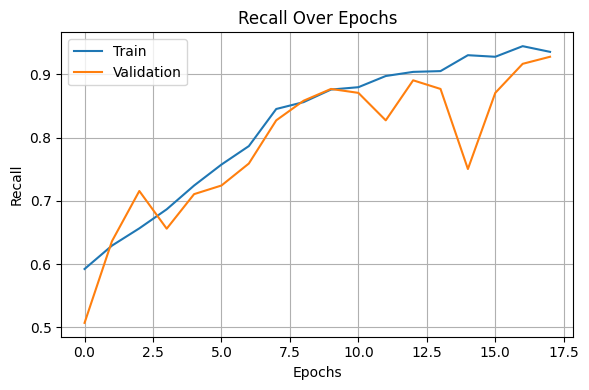

In [ ]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Step 2: Install required libraries
!pip install seaborn matplotlib --quiet

# ✅ Step 3: Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

# ✅ Step 4: Load saved files
y_true = np.load('/content/drive/MyDrive/BILSTM_MODEL/y_true.npy')
y_prob = np.load('/content/drive/MyDrive/BILSTM_MODEL/y_prob.npy')

# ✅ Step 5: Convert probabilities to predicted labels
y_pred = (y_prob > 0.5).astype(int).flatten()

# ✅ Step 6: Save y_pred (optional, only once)
np.save('/content/drive/MyDrive/BILSTM_MODEL/y_pred.npy', y_pred)

# ✅ Step 7: Print Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 Test Accuracy: {acc*100:.2f}%")

# ✅ Step 8: Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("🧠 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ Step 9: Plot Training History from history.pkl
try:
    with open('/content/drive/MyDrive/BILSTM_MODEL/history.pkl', 'rb') as f:
        history_data = pickle.load(f)

    def plot_metric(metric):
        plt.figure(figsize=(6, 4))
        plt.plot(history_data[metric], label='Train')
        plt.plot(history_data['val_' + metric], label='Validation')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    print("\n📈 Plotting training curves...")
    plot_metric('accuracy')
    plot_metric('loss')
    plot_metric('precision')
    plot_metric('recall')

except Exception as e:
    print("⚠️ Could not load training history:", e)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# ✅ Step 1: Basic Metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📊 Model Evaluation Metrics:")
print(f"✅ Accuracy  : {acc*100:.2f}%")
print(f"✅ Precision : {precision*100:.2f}%")
print(f"✅ Recall    : {recall*100:.2f}%")
print(f"✅ F1 Score  : {f1*100:.2f}%")

# ✅ Step 2: Full classification report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Interictal (0)", "Preictal (1)"]))



📊 Model Evaluation Metrics:
✅ Accuracy  : 83.53%
✅ Precision : 89.76%
✅ Recall    : 87.18%
✅ F1 Score  : 88.45%

🧾 Classification Report:
                precision    recall  f1-score   support

Interictal (0)       0.69      0.74      0.71       384
  Preictal (1)       0.90      0.87      0.88      1006

      accuracy                           0.84      1390
     macro avg       0.79      0.81      0.80      1390
  weighted avg       0.84      0.84      0.84      1390

